In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace import sarimax

from load_dataset import Dataset
import plotting

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:
dataset = Dataset('../data/Dataset')

In [96]:
ts = dataset['international-airline-passengers.csv']
ts.index = ts.index.map(pd.to_datetime)

In [97]:
ts, ts_test = ts[:100], ts[100:]

<AxesSubplot:xlabel='1949-01'>

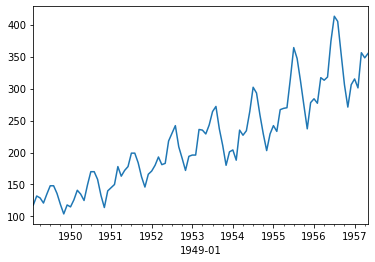

In [98]:
ts.plot()

#### Задание 1. Box-Jenkins approach
1. Убрать гетероскедастичность при помощи логарифмирования.
2. Продифференцировать разными способами и узнать нужный порядок дифференцирования d, D, анализируя
   получившийся ряд при помощи графика acf_plot.
3. Оценить параметры (q, Q), (p, P) по графикам acf, pacf продифференцированного ряда.
4. Обучить модель SARIMA и попробовать сделать предсказания исходного ряда.
5. Критерий хорошей модели (в идеале) - стационарные остатки.

In [108]:
ts_log = np.log(ts)
plotting.plot_ts(ts_log)

Loading BokehJS ...

<AxesSubplot:xlabel='1949-01'>

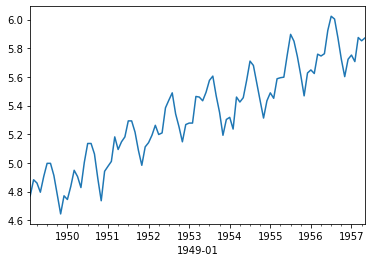

In [100]:
ts_log.plot()

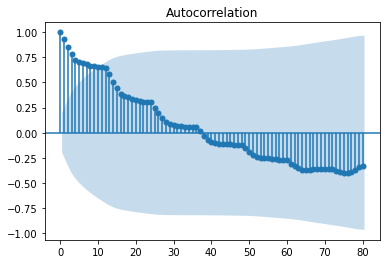

In [104]:
plot_acf(ts_log, lags=80);

<AxesSubplot:xlabel='1949-01'>

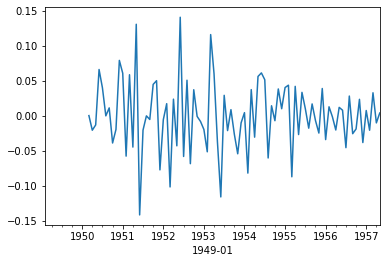

In [109]:
ts_log.diff().diff(12).plot()

In [112]:
adfuller(ts_log.diff().diff(12).diff(12).dropna())[1]

0.0004917196945686068

In [121]:
ts_flat = ts_log.diff().diff(12).dropna()

<AxesSubplot:xlabel='1949-01'>

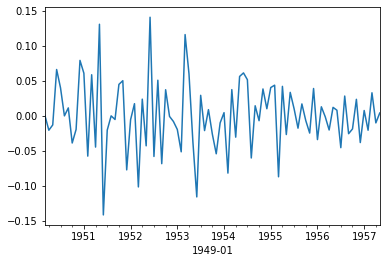

In [122]:
ts_flat.plot()

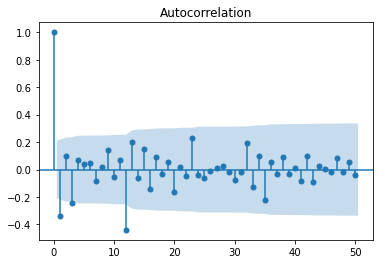

In [123]:
# отлично, для поиска параметров q, Q нарисуем график автокорреляций
# последний значимый несезонный лаг определяется как последний лаг, котоырй еще не пересек
# интервал значимости по модулю (то есть ВСЕ лаги от нулевого до него были выше порога значимости).
# В данном случае он равен 0 (не забываем, что считаем мы с нуля - нулевого лага).
# Аналогично Q определятся как последний сезонный лаг, который не пересек порог значимости. В данном
# случае 1.
# Итак q = 1, Q = 1
plot_acf(ts_flat.dropna(), lags=50);

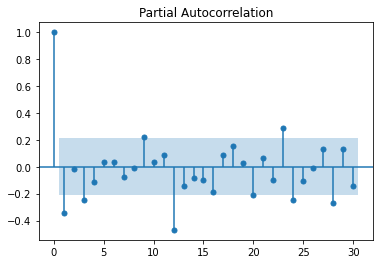

In [124]:
# теперь разберемся с параметрами p, P
# здесь видно, что последний значимый несезонный лаг равен 2
# а последний значимый сезонный лаг равен 0
# итак, p = 1, P = 2
plot_pacf(ts_flat, lags=30);

In [125]:
from statsmodels.tsa.statespace import sarimax

In [171]:
pdq = (0, 1, 1)
PDQ = (0, 1, 1, 12)

In [172]:
model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [173]:
res = model.fit()

In [174]:
preds = res.forecast(43)

In [175]:
plotting.plot_ts(ts_log, preds)

Loading BokehJS ...

In [176]:
# восстановим в изначальном масштабе
plotting.plot_ts(np.exp(ts_log), np.exp(preds), ts_test)

Loading BokehJS ...

In [177]:
res = (np.exp(preds) - ts_test)

<AxesSubplot:>

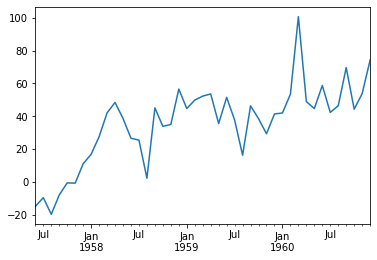

In [178]:
res.plot()

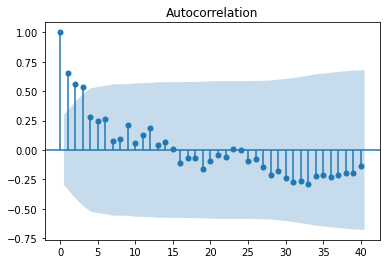

In [167]:
plot_acf(res, lags=40);

In [183]:
adfuller(res)

TypeError: float() argument must be a string or a number, not 'SARIMAXResultsWrapper'

In [17]:
# <ваш код здесь>

#### Задание 2. (используя критерий Акаике)
1. Взять параметры дифференцирования d, D из задания 1.
2. Выбрать сетку гиперпараметров (не брать большие значения).
3. Для кадого набора параметров:
    * обучить модель SARIMAX на логарифмированном ряде (все остальные преобразования к стационарному ряду модель сделает за вас)
    * получить aic модели (хранится в аттрибуте aic обученной модели)
    * запомнить aic для такого-то набора параметров
4. Выбрать модель с набором гиперпараметров, дающих минимальный aic.
5. Сделать предсказание ts_log на тестовую выборку. 
6. Восстановить предсказания обратным преобразованием.
7. Проанализировать остатки

In [18]:
def calculate_akaike(y_true: np.array, y_pred: np.array, n_params: int):
    L = sum((y_true - y_pred)**2)
    n = len(y_true)
    return 2*n_params + n*np.log(L)

In [19]:
calculate_akaike(ts[-30:].values, ts[-30:].values+1, 100)

302.03592144986465

In [179]:
dct_res = {}
min_aic = 10
pdq_PDQ = ' '
for p_i in range(5):
    for P_i in range(5):
        for q_i in range(5):
            for Q_i in range(3):
                
                pdq = (p_i, 1, q_i)
                PDQ = (P_i, 1, Q_i, 12)
                
                model = sarimax.SARIMAX(ts_log, order=pdq, seasonal_order=PDQ)
                res = model.fit()
                dct_res[pdq+PDQ] = res.aic
                
                if res.aic < min_aic:
                    min_aic = res.aic
                    pdq_PDQ = pdq+PDQ

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency informa

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood opt

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency inf

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency

In [181]:
pdq_PDQ

(0, 1, 1, 0, 1, 1, 12)

In [9]:
# ваш код здесь

#### Задание 3. (используя auto-arima)
1. Установить аналог auto-arima из R, библиотеку pmdarima (pip install pmdarima)
2. Обучить модель, используя функцию auto_arima, передав в нее нужные параметры.